In [270]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import re
import json
import pandas as pd
import geopandas as gpd

In [271]:
fred_input_folder = '/zine/HPC02S1/ex-dveloza/AGORA/apps/fred_colombia_implementation/fred_input_files'
synthetic_pop_data_folder = '/zine/HPC02S1/ex-dveloza/AGORA/apps/synthetic_populations/data'

In [272]:
df_0 = pd.read_csv(f'{fred_input_folder}/facebook_open_data/movement-range-data-2020-03-01--2020-12-31.txt', sep='\t', low_memory=False)
df_1 = pd.read_csv(f'{fred_input_folder}/facebook_open_data/movement-range-2022-05-22.txt', sep='\t', low_memory=False)

In [273]:
metadata_file = f"{synthetic_pop_data_folder}/param_files/colombia_municipios_metadata.json"
gadm_file = f'{fred_input_folder}/gadm_data/gadm41_COL_2.shp'

In [274]:
# Load JSON data from a file
with open(metadata_file, 'r') as file:
    json_data = json.load(file)

# Initialize an empty DataFrame
colombia_municipalities_info = pd.DataFrame(columns=['department_name', 'department_code', 'mun_name', 'divipola_code'])

# Instead of using append, we'll construct a list of dictionaries and convert it to a DataFrame at the end
rows = []

for department_name, department_data in json_data['colombia'].items():
    for mun_name, mun_data in department_data.items():
        department_code = mun_data['department_code'][0]
        divipola_code = mun_data['divipola_code'][0]

        new_row = {'department_name': department_name, 'department_code': department_code, 
                   'mun_name': mun_name, 'divipola_code': divipola_code}
        rows.append(new_row)

# Convert the list of dictionaries to a DataFrame
colombia_municipalities_info = pd.DataFrame(rows)


# Data transformations
colombia_municipalities_info['department_name'] = colombia_municipalities_info['department_name'].replace(
    {"ARCHIPIÉLAGO DE SAN ANDRÉS PROVIDENCIA Y": "SAN ANDRÉS Y PROVIDENCIA"})

# For Latin-ASCII transformation, you might need a library like `unidecode`
from unidecode import unidecode
colombia_municipalities_info['mun_name'] = colombia_municipalities_info['mun_name'].apply(unidecode)
colombia_municipalities_info['department_name'] = colombia_municipalities_info['department_name'].apply(unidecode)

In [275]:
facebook_data = pd.concat([df_0[(df_0.country == 'COL')].copy(), df_1[(df_1.country == 'COL')].copy()])

In [276]:
# Function to select the preferred polygon_name
def select_preferred_name(group):
    preferred_names = group['polygon_name'][~group['polygon_name'].str.contains('-')]
    if not preferred_names.empty:
        return preferred_names.iloc[0]
    else:
        return group['polygon_name'].iloc[0]

# Group by polygon_id and apply the function
standardized_names = facebook_data.groupby('polygon_id').apply(select_preferred_name)

# Map the standardized names back to the original dataframe
facebook_data['polygon_name'] = facebook_data['polygon_id'].map(standardized_names)

In [277]:
gadm_shp = gpd.read_file(gadm_file)


In [278]:
facebook_data['polygon_name'] = facebook_data['polygon_name'].str.upper()

In [279]:
# Extracting numbers from string fields
facebook_data['num_dpto'] = facebook_data['polygon_id'].str.extract(r"(?<=\.)(\d+)").astype(float)
facebook_data['num_mun'] = facebook_data['polygon_id'].str.extract(r"(?<=\.)(\d+)(?=_1)").astype(float)

# Conditional mutations
facebook_data['num_dpto'] = np.where(facebook_data['num_dpto'] >= 5, facebook_data['num_dpto'] + 1, facebook_data['num_dpto'])
facebook_data['num_dpto'] = np.where(facebook_data['polygon_name'] == "SANTAFÉ DE BOGOTÁ", 5, facebook_data['num_dpto'])
facebook_data['num_mun'] = np.where(facebook_data['polygon_name'] == "SANTAFÉ DE BOGOTÁ", 1, facebook_data['num_mun'])
facebook_data['polygon_name'] = np.where(facebook_data['polygon_name'] == "SANTAFÉ DE BOGOTÁ", "BOGOTÁ D.C.", facebook_data['polygon_name'])

# Processing gadm_dpto_data
# Assuming 'gadm_shp' is a geopandas GeoDataFrame and has been appropriately loaded
gadm_dpto_data = gadm_shp.copy()
gadm_dpto_data = gadm_dpto_data[['GID_2', 'NAME_1', 'NAME_2']]
gadm_dpto_data['num_dpto_gadm'] = gadm_dpto_data['GID_2'].str.extract(r"(?<=\.)(\d+)").astype(float)
gadm_dpto_data = gadm_dpto_data.rename(columns={"GID_2": "true_polygon_id", "NAME_1": "name_dpto", "NAME_2": "name_mun"})
gadm_dpto_data = gadm_dpto_data[['num_dpto_gadm', 'name_dpto']].drop_duplicates()
gadm_dpto_data['name_dpto'] = gadm_dpto_data['name_dpto'].str.upper()
# You might need an additional library for string translations, like 'unidecode'
from unidecode import unidecode
gadm_dpto_data['name_dpto'] = gadm_dpto_data['name_dpto'].apply(unidecode)

# Joining DataFrames
colombia_municipalities_info = pd.merge(colombia_municipalities_info, gadm_dpto_data, left_on="department_name", right_on="name_dpto", how="left")

# Replacements
replacement_values = {
  "PURISIMA"                    : "PURISIMA DE LA CONCEPCION",
  "SAN BERNARDINO DE SAHAGUN"   : "SAHAGUN",
  "SANTA CRUZ DE LORICA"        : "LORICA",
  "PUERTO INIRIDA"              : "INIRIDA",
  "SANTA MARTA (DIST. ESP.)"    : "SANTA MARTA",
  "DON MATIAS"                  : "DONMATIAS",
  "LA UNION DE SUCRE"           : "LA UNION",
  "SAN VICENTE"                 : "SAN VICENTE FERRER",
  "SAN LUIS DE CUBARRAL"        : "CUBARRAL",
  "VISTA HERMOSA"               : "VISTAHERMOSA",
  "SAN JOSE DE CUCUTA"          : "CUCUTA",
  "SAN MIGUEL DE MOCOA"         : "MOCOA",
  "SANTIAGO DE CALI"            : "CALI",
  "SAN JUAN DE PASTO"           : "PASTO",
  "SINCE"                       : "SINCELEJO",
  "TOLU"                        : "SANTIAGO DE TOLU",
  "ARMERO"                      : "ARMERO GUAYABAL",
  "TUMACO"                      : "SAN ANDRES DE TUMACO",
  'BAH-A SOLANO' : 'BAHIA SOLANO', 
  'FUNDACI-N' : 'FUNDACION', 
  'BURITIC-' : 'BURITICA', 
  'C-RDOBA' : 'CORDOBA', 
  'CHITAG-' : 'CHITAGA',
  'EL CARMEN DE CHUCUR-' : 'EL CARMEN DE CHUCURI',
  'MIT-' : 'MITU', 
  'MARIP-' : 'MARIPI'
}

facebook_data['polygon_name'] = facebook_data['polygon_name'].apply(unidecode)
facebook_data['polygon_name'] = np.where(
    (facebook_data['num_dpto'] == 2) & (facebook_data['polygon_name'] == "BOLIVAR"),
    "CIUDAD BOLIVAR",
    facebook_data['polygon_name'].replace(replacement_values)
)

# Final join for facebook_data_divipola_code
facebook_data_divipola_code = pd.merge(facebook_data, colombia_municipalities_info, left_on=["polygon_name", "num_dpto"], right_on=["mun_name", "num_dpto_gadm"], how="left")

In [280]:
facebook_data_divipola_code[facebook_data_divipola_code.department_code.isna()].polygon_name.unique()

array([], dtype=object)

In [281]:
for dept_code in facebook_data_divipola_code.department_code.unique():
    print(f'Processing : {dept_code}')
    facebook_dept_data = facebook_data_divipola_code[facebook_data_divipola_code.department_code == dept_code].copy()

    facebook_dept_data['mobility_trend'] = facebook_dept_data['all_day_bing_tiles_visited_relative_change']
    facebook_dept_data['shelter_trend'] = facebook_dept_data['all_day_ratio_single_tile_users']
    facebook_dept_data['date'] = pd.to_datetime(facebook_dept_data['ds'])

    tmp_shelter = facebook_dept_data[['date', 'shelter_trend']]
    tmp_shelter = tmp_shelter.groupby('date', as_index=False)['shelter_trend'].mean()

    df_shelter = tmp_shelter.groupby(tmp_shelter['date'].dt.floor('d')).agg({'shelter_trend': 'mean'}).reset_index()
    df_shelter = df_shelter.sort_values(by='date')

    tmp_mov = facebook_dept_data[['date', 'mobility_trend']]
    tmp_mov = tmp_mov.groupby('date', as_index=False)['mobility_trend'].mean()

    df_mobility = tmp_mov.groupby(tmp_mov['date'].dt.floor('d')).agg({'mobility_trend': 'mean'}).reset_index()
    df_mobility = df_mobility.sort_values(by='date')

    df_mobility.to_csv(f'{fred_input_folder}/mobility_trends/{dept_code}_mobility_trends.csv', index=False)
    df_shelter.to_csv(f'{fred_input_folder}/shelter_trends/{dept_code}_shelter_trends.csv', index=False)

Processing : 91
Processing : 19
Processing : 20
Processing : 27
Processing : 23
Processing : 25
Processing : 11
Processing : 94
Processing : 95
Processing : 41
Processing : 44
Processing : 47
Processing : 5


Processing : 50
Processing : 52
Processing : 54
Processing : 86
Processing : 63
Processing : 66
Processing : 88
Processing : 68
Processing : 70
Processing : 73
Processing : 81
Processing : 76
Processing : 97
Processing : 99
Processing : 8
Processing : 13
Processing : 15
Processing : 17
Processing : 18
Processing : 85


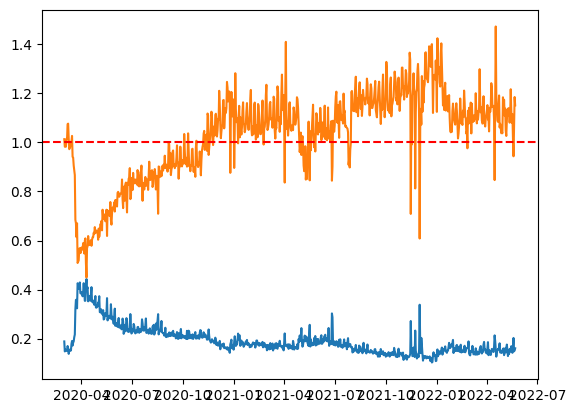

In [282]:
plt.plot(df_shelter.date, df_shelter.shelter_trend)
plt.plot(df_mobility.date, 1 + df_mobility.mobility_trend)

plt.axhline(y=1, color='r', linestyle='--')
#plt.xlim(dt.date(2020,3,1), dt.date(2020,11,1))

In [283]:
#synth_household_file = f'../../../synthetic_populations/output/formatted_populations/colombia_{dept_code}/colombia_{dept_code}_synth_households.txt'
#house_esc = pd.read_csv(synth_household_file)

#house_esc['ESC'] = (str(dept_code) + house_esc['stcotrbg'].astype(str).str[-3:]).astype(int)

#grouped = house_esc.groupby('ESC')['hh_size'].sum().reset_index(name='N')

#total_N = grouped['N'].sum()
#grouped['Mun_prop'] = grouped['N'] / total_N

#df_trend = df_test.merge(grouped, how='left', left_on='divipola_code', right_on='ESC')